# Bias corrections for the csat temperatures -- Bayesian inference

### Goals of the notebook:
- robustly identify periods with neutral stability using a Bayesian linear regression technique (results from `estimating-stability_bayesian-stats.v2-2021-02-18.ipynb`)
- Determine an offest correction for the sonic temperatures to remove biases
- Repeat using periods with cloud cover and low sensible heat fluxes


### Results of the notebook:

- estimating stability during periods of near-neutral conditions is actually not straight forward. The same may be true for periods with stronger positive stability when multiple layers present, but has not been tested.
- Stability estimates from just sonic observations are strongly biased relative to those from the Bayes GLM estimates with the DTS tower. 4 point observations are insufficient for sampling the temperature gradient, at least at a 10 minute interval.
- Bayes vs OLS GLM has some differences, especially during strongly stable conditions when multiple layers may be present.

### Change log:

- 2021-02-21: use the homogenized data from the "homogenized_data" directory to simplify analysis.
- 2021-06-01: 
        - changed the reference pressure to be 100kPa and not sea level pressure.
        - Converted sonic temperature to air temperature

# 1. Import and formatting

In [2]:
# Data and methods libraries
import numpy as np
import xarray as xr
import scipy.stats
import pandas as pd

# OS interaction
import os

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import string
import datetime
import copy
import warnings

## Format plots

In [3]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context(context)

# Define a default color palette, which should be fairly color blind friendly). The
# last purple is a bit similar to the blue for red blindness.
flatui = ["#3498db", "#FFBF00", "#34495e", "#95a5a6", "#e74c3c", "#9b59b6",]
sns.set_palette(sns.color_palette(flatui))

# Define a line style list
ls_list = ['-', '--', ':', '-']
ms_list = ['v', '*', 's', 'o']

alphabet = list(string.ascii_lowercase)

## Directories

In [4]:
dir_pre = os.path.join('/Users/karllapo/Dropbox/DarkMix/proj/DarkMix_Voitsumra/')

# Met data
dir_logger_data = os.path.join(dir_pre, 'logger_data')
dir_aws_data = os.path.join(dir_logger_data, 'AWS')
dir_csat_stats = os.path.join(dir_logger_data, 'CSATs', 'stats')
dir_csat_flux = os.path.join(dir_logger_data, 'CSATs', 'fluxes')
dir_csat_corr = os.path.join(dir_logger_data, 'CSATs', 'csat-Ts-correction')
dir_ceil = os.path.join(dir_pre, 'love_dts/ESSD-repository/remote-sensing/ceilometer/')
dir_press = os.path.join(dir_logger_data, 'pressure')
dir_homogenized_data = os.path.join(dir_pre, 'homogenized_data')

# Figures
dir_print = os.path.join(dir_pre, 'figures', 'AncillaryMet')


## Dictionaries of metadata

In [5]:
csat_names = {'LOVE19_CSATs_00p5m': '0.5m',
              'LOVE19_CSATs_01m': '1m',
              'LOVE19_CSATs_04m': '4m',
              'LOVE19_CSATs_12m': '12m',}
# Actual recorded heights
csat_heights = {'LOVE19_CSATs_00p5m': -1.04911579,
                'LOVE19_CSATs_01m': -0.308039694,
                'LOVE19_CSATs_04m': 2.536769369,
                'LOVE19_CSATs_12m': 10.43707809,}

# Remove an additional 10cm since we didn't measure the exact bottom.
tower_bottom = -1.448183004 - 0.1
tower_bottom_fiberholder = -1.338927283

# Adjust everything to the local height above ground.
for csat in csat_heights:
    csat_heights[csat] = csat_heights[csat] - tower_bottom

tower_bottom_fiberholder = tower_bottom_fiberholder - tower_bottom

# 2. Load data

## 2.1 Sonic data

I use the original sonic/bmmflux output and calculate potential temperature separately (see below).

In [6]:
os.chdir(dir_csat_flux)
sonic_orig = xr.open_dataset('LOVE19_CSAT_1min_fluxes.v2020-12-03.nc')
sonic_orig

<xarray.Dataset>
Dimensions:                (names: 4, time: 106319)
Coordinates:
  * time                   (time) datetime64[ns] 2019-06-01T14:30:00 ... 2019...
    z                      (names) float64 ...
  * names                  (names) object '0.5m' '1m' '4m' '12m'
Data variables: (12/72)
    Datetime_center        (names, time) float64 ...
    zenith                 (names, time) float64 ...
    azimuth                (names, time) float64 ...
    DayNightIndicator      (names, time) float64 ...
    num_data               (names, time) float64 ...
    num_NaN_uvwTs          (names, time) float64 ...
    ...                     ...
    itc_w                  (names, time) float64 ...
    itc_Ts                 (names, time) float64 ...
    ti_u                   (names, time) float64 ...
    ti_v                   (names, time) float64 ...
    ti_w                   (names, time) float64 ...
    num_lag_wTs            (names, time) float64 ...
Attributes:
    z_aero:   Aerodynamic height (z-d), where d=displacement height = 0.366667m

## 2.2 Ceilometer, AWS, and pressure data

- Ceilometer for cloudiness
- AWS for radiation and RH
- pressure for potential temperature calculations

In [7]:
os.chdir(dir_ceil)
ceilo = xr.open_dataset('ceiolometer-combined-files_2019_June01-Aug15.nc')
ceilo = ceilo.reindex_like(sonic_orig.time, method='nearest')
ceilo

<xarray.Dataset>
Dimensions:   (layer: 5, range: 2002, time: 106319)
Coordinates:
  * time      (time) datetime64[ns] 2019-06-01T14:30:00 ... 2019-08-14T10:28:00
  * layer     (layer) int32 1 2 3 4 5
  * range     (range) float32 4.995 9.99 14.98 ... 9.99e+03 9.995e+03 1e+04
Data variables:
    beta_att  (time, range) float32 ...
    pbl       (time, layer) int16 ...
    pbs       (time, layer) int8 ...
    tcc       (time) int8 ...
    sci       (time) int8 ...
    vor       (time) int16 ...
    mxd       (time) int16 ...
    cbh       (time, layer) int16 ...
Attributes: (12/13)
    title:             CHM8k
    source:            CHM198101
    device_name:       CHM198101
    serlom:            TUB198003
    day:               1
    month:             6
    ...                ...
    location:          Voi
    institution:       UBT-MM
    wmo_id:            0
    software_version:  18.10.1 4.17 1.010 1
    comment:           
    overlap_file:      TUB198003 (2019-04-11 12:15:47)

In [8]:
os.chdir(dir_aws_data)
aws = xr.open_dataset('AWS_Voi_1min.nc')
aws

<xarray.Dataset>
Dimensions:                      (time: 85445)
Coordinates:
  * time                         (time) datetime64[ns] 2019-06-20T14:03:00 .....
Data variables: (12/16)
    air temperature 2m (HMP45)   (time) float64 ...
    air temperature 5cm (PT100)  (time) float64 ...
    prec (pluvio)                (time) float64 ...
    prec (tipping bucket)        (time) float64 ...
    Rad body temp (CNR4)         (time) float64 ...
    rel humidity 2m (HMP45)      (time) float64 ...
    ...                           ...
    soil temp -05 cm             (time) float64 ...
    soil temp -25 cm             (time) float64 ...
    soil temp -50 cm             (time) float64 ...
    wind direction               (time) int64 ...
    windspeed 2m avg             (time) float64 ...
    windspeed 2m max             (time) float64 ...

### 2.2.1 Load the pressure data

In [9]:
os.chdir(dir_press)
press = xr.open_dataset('pressure_1min_stats.nc')
press

<xarray.Dataset>
Dimensions:               (time: 57386)
Coordinates:
  * time                  (time) datetime64[ns] 2019-06-13T16:30:00 ... 2019-...
Data variables: (12/31)
    BattVolt_Min          (time) float64 ...
    Max_bytes_returned_1  (time) int64 ...
    Max_bytes_returned_2  (time) int64 ...
    Max_bytes_returned_3  (time) int64 ...
    Max_bytes_returned_4  (time) int64 ...
    P1_Avg                (time) float64 ...
    ...                    ...
    n_nnd_3_TOT           (time) int64 ...
    n_nnd_4_TOT           (time) int64 ...
    n_samples_1_TOT       (time) int64 ...
    n_samples_2_TOT       (time) int64 ...
    n_samples_3_TOT       (time) int64 ...
    n_samples_4_TOT       (time) int64 ...

### 2.2.2 Gap fill

Text(0.5, 1.0, 'Pressure data with gap filling')

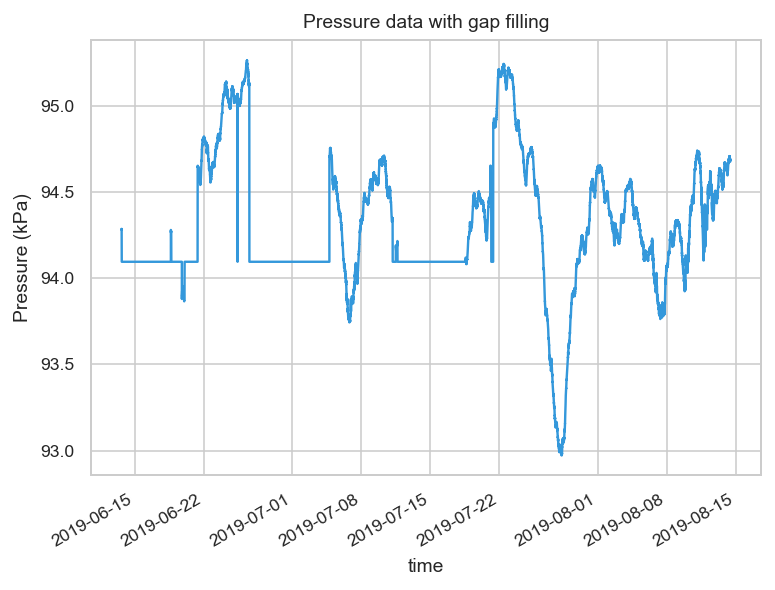

In [59]:
# Take the average pressure across the 4 stations (convert to kPa)
press_avg = xr.concat([press.P1_Avg, press.P2_Avg, press.P3_Avg, press.P4_Avg,], dim='station')
press_avg = press_avg.mean(dim='station') / 10

# Estimate pressure for the gapped periods
z_site = 620 # elevatio above sea level
press_sealvl = 101.325
# For consistenty with Christoph's estimate use the Barometric Formula.
press_gap = press_sealvl * (1 - (0.0065 * z_site) / 288.15) ** 5.255
# Standard reference pressure for potential temperature
press_stnd_ref = 100.

# Fill the gaps
press_avg = press_avg.reindex(
    time=pd.date_range(
        press_avg.time.values[0],
        press_avg.time.values[-1],
        freq='1min'
    )
)
press_avg = press_avg.where(~np.isnan(press_avg), press_gap)
press_avg.plot()
plt.gca().set_ylabel('Pressure (kPa)')
plt.gca().set_title('Pressure data with gap filling')

## 2.3 Load the DTS data

In [11]:
os.chdir('/Users/karllapo/Dropbox/DarkMix/proj/DarkMix_Voitsumra/love_dts/ESSD-repository/FODS_tower/')
tower = xr.open_dataset('phaseII.tower.cold.nc')
tower

<xarray.Dataset>
Dimensions:     (time: 1090221, xyz: 80)
Coordinates:
    x           (xyz) float64 ...
    z           (xyz) float64 ...
    LAF         (xyz) float64 ...
    northcones  (xyz) object ...
    unheated    (xyz) object ...
    southcones  (xyz) object ...
    y           (xyz) float64 ...
    heated      (xyz) object ...
    eastcones   (xyz) object ...
  * time        (time) datetime64[ns] 2019-07-15T11:23:31 ... 2019-07-29T21:2...
Dimensions without coordinates: xyz
Data variables:
    cal_temp    (time, xyz) float64 ...
Attributes:
    dt:          1s
    dLAF:        0.127
    heated:      tower;NSH_0.5m;NSH_1m;NSH_2m;EWH_0.5m;EWH_1m;EWH_2m;VM;VN_o;...
    eastcones:   EWH_0.5m;EWH_1m;EWH_2m
    southcones:  NSH_0.5m;NSH_1m;NSH_2m
    northcones:  NSH_0.5m;NSH_1m;NSH_2m
    unheated:    tower;mane_south;mane_north;NSH_0.5m;NSH_1m;NSH_2m;EWH_0.5m;...

Exclude the period with poor DTS evaluation. Since the beginning of the excluded period is so close to the beginning of the DTS data, I'll just select times after the DTS behavior stabilizes.

In [12]:
t1 = '2019-07-16 15:00'
t2 = '2019-07-20 09:00'

tower = tower.sel(time=slice(t2, None))

# 3. Calculate Potential Temperatures

## 3.1 FODS potential temperature

In [15]:
press_dt = press_avg.interp_like(tower.time)
tower['theta'] = (('time', 'xyz'), (tower.cal_temp + 273.15) * (press_stnd_ref / press_dt) ** (2/7) - 273.15) 

## 3.2 AWS 2m potential temperature

In [16]:
press_dt = press_avg.interp_like(aws.time)
aws_2m_theta = ((aws['air temperature 2m (HMP45)'] + 273.15) * (press_stnd_ref / press_dt) ** (2/7) - 273.15)

## 3.3 Sonic temperatures and potential temperatures

Here I use the original bmmflux output instead of Christoph's data. This is because I want to ensure consistency with the potential temperaures from the tower DTS and the AWS and I use the observed pressure data to calculate these quantities.

Sonic temperature needs to be converted to air temperature using the below expression (https://amt.copernicus.org/articles/5/2095/2012/amt-5-2095-2012.pdf)

$T^{s}_{air} = \frac{T_s}{1 + 0.51 q}$

where $T^{s}_{air}$ is the air temperature calculated from sonic temperature in a moist atmosphere, $T_s$ is the sonic temperature, and $q$ is the specific humidity.

#### First, some useful functions

In [31]:
def mixing_ratio(e, p):
    # Equation 3a, mixing ratio of water vapor
    # e is water vapor pressure in hPa
    # p is air pressure in hPa
    r_v = 0.622 * e / (p - 0.378 * e)
    return r_v


def sonic_temp_conversion(Ts, q):
    T_air = Ts / (1 + 0.51 * q)
    return T_air


def e_s_wmo(T):
    # Equation 3b Saturated water vapor pressure
    
    # Make sure we are in celsius
    if np.max(T) > 200:
        T = T - 273.15
    
    # Constants
    c1 = 6.112
    c2 = 17.62
    c3 = 243.12
    
    # WMO approximation
    e_s = c1 * np.exp(c2 * T / (c3 + T))
    return e_s

In [34]:
press_dt = press_avg.interp_like(sonic_orig.time)
# Saturation vapor pressure
es = e_s_wmo(aws['air temperature 2m (HMP45)'])
es = es.interp_like(sonic_orig.time)
# Relative humidity
rh_dt = aws['rel humidity 2m (HMP45)']
rh_dt = rh_dt.interp_like(sonic_orig.time)

# Vapor pressure
e = es * rh_dt / 100

# Mixing ratio
r_v = mixing_ratio(e, press_dt)

sonic_orig['air_temperature'] = sonic_temp_conversion(sonic_orig.Ts_mean, r_v / (1 + r_v))

In [46]:
press_dt = press_avg.interp_like(sonic_orig.time)
sonic_orig['theta'] = (('names', 'time'), (sonic_orig.air_temperature + 273.15) * (press_stnd_ref / press_dt) ** (2/7) - 273.15)

### 3.3.1 QC the sonic data

Drop hours with deeply unphysical temperatures jumps (dT/dt > 4.5K/min). This threshold corresponds to the 99.9th percentile of jumps at the 0.5m height.

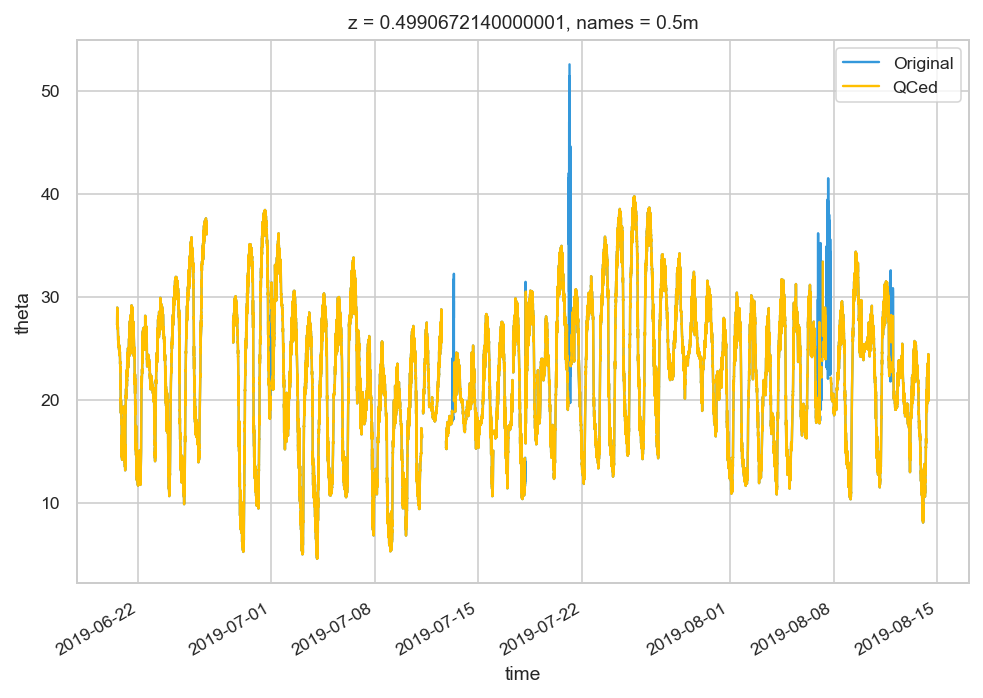

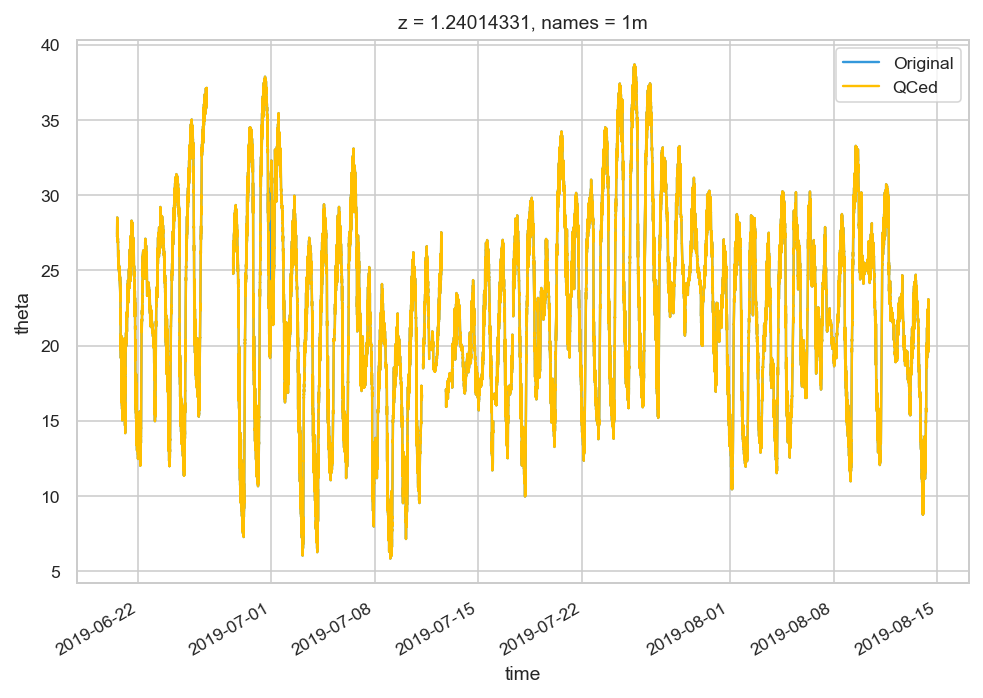

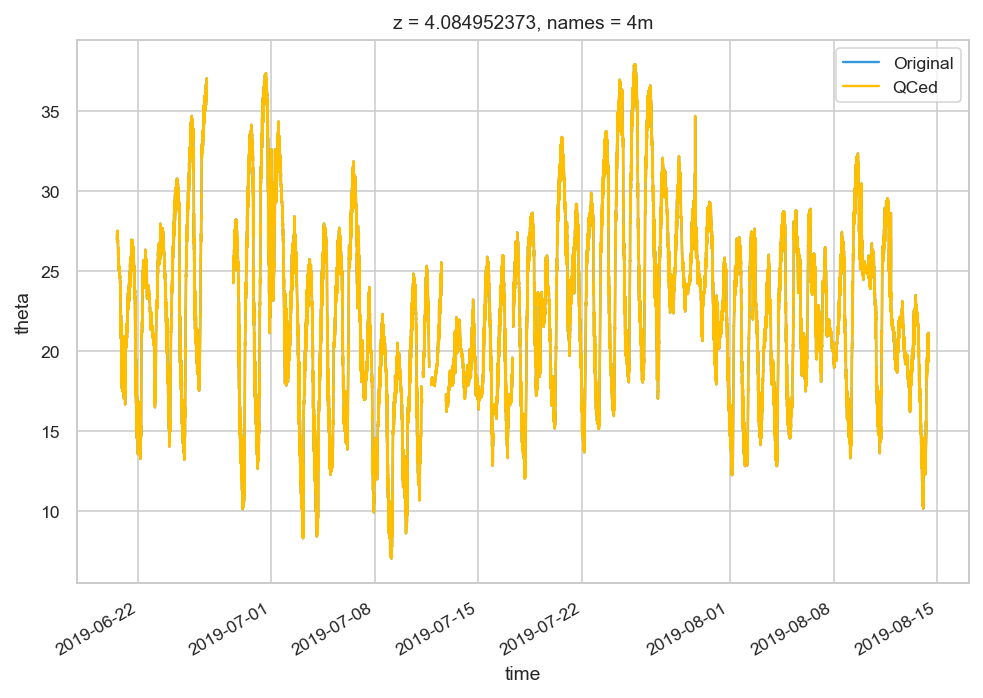

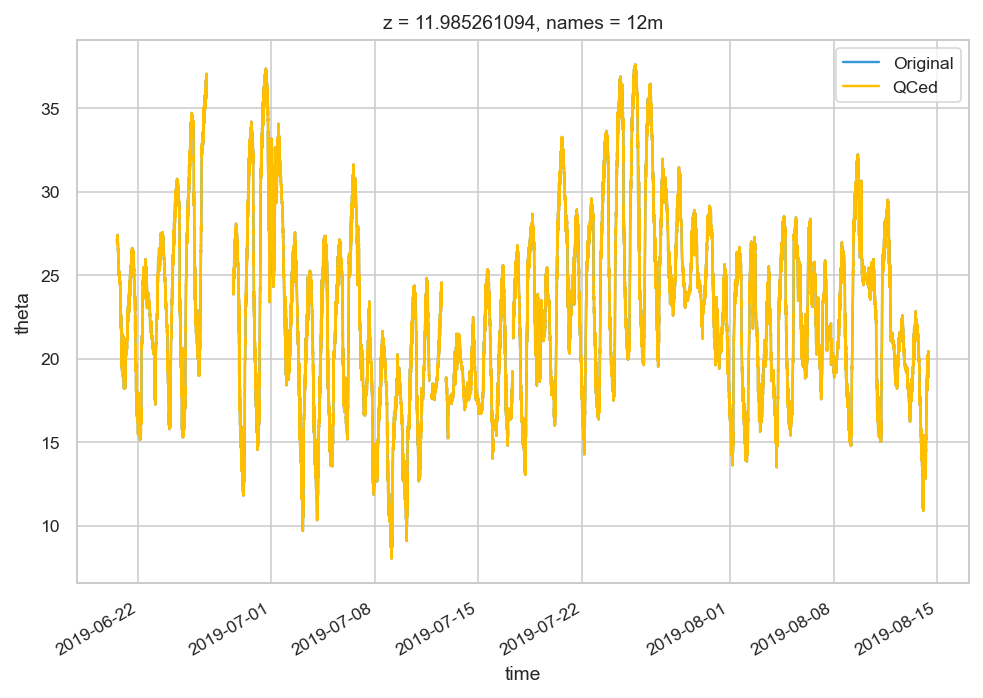

In [47]:
sonic_1min_qc = copy.deepcopy(sonic_orig)

# Now to remove bad jumpy periods.
for name in sonic_1min_qc.names:
    # Difference along the time dimension (not perfect but close enough)
    diff = sonic_1min_qc.theta.sel(names=name).diff(dim='time')
    # Use the 99.9th percentile from the 0.5m sonic
    quantile = 4.5
    # Get the hours with large jumps, downsample back to 1 minute time step
    bad_index = (np.abs(diff) > quantile).resample(time='1h').mean().resample(time='1min').interpolate('nearest').reindex_like(sonic_1min_qc)
    # Drop the intervals with bad jumps within an hour
    sonic_1min_qc.theta.loc[{'names': name}] = sonic_1min_qc.theta.loc[{'names': name}].where(~(bad_index > 0))
    
# Visualize what that did for each sonic individually
for name in sonic_1min_qc.names:
    plt.figure(figsize=(8, 5))
    sonic_orig.sel(names=name).theta.plot(label='Original')
    sonic_1min_qc.sel(names=name).theta.plot(label='QCed')
    plt.legend()

# 4 Subset and aggregate the data

## 4.1 Tower @ 1-minute scale

In [48]:
tower_1min_resample = tower.theta.resample(time='1min')

tower_1min = tower_1min_resample.mean()
tower_1min = xr.DataArray.to_dataset(tower_1min, name='theta_mean')
tower_1min['theta_std'] = (('time', 'xyz'), tower_1min_resample.std())
tower_1min['theta_q10'] = (('time', 'xyz'), tower_1min_resample.quantile(0.1))
tower_1min['theta_q90'] = (('time', 'xyz'), tower_1min_resample.quantile(0.9))
tower_1min

<xarray.Dataset>
Dimensions:     (time: 13710, xyz: 80)
Coordinates:
  * time        (time) datetime64[ns] 2019-07-20T09:00:00 ... 2019-07-29T21:2...
    x           (xyz) float64 -14.15 -14.14 -14.14 ... -13.87 -13.87 -13.86
    z           (xyz) float64 0.7173 0.8461 0.9749 1.104 ... 10.64 10.77 10.9
    LAF         (xyz) float64 181.9 182.1 182.2 182.3 ... 191.7 191.9 192.0
    northcones  (xyz) object '' '' '' '' '' '' '' '' ... '' '' '' '' '' '' '' ''
    unheated    (xyz) object 'tower' 'tower' 'tower' ... 'tower' 'tower' 'tower'
    southcones  (xyz) object '' '' '' '' '' '' '' '' ... '' '' '' '' '' '' '' ''
    y           (xyz) float64 -9.188 -9.189 -9.19 -9.191 ... -9.278 -9.279 -9.28
    heated      (xyz) object '' '' '' '' '' '' '' '' ... '' '' '' '' '' '' '' ''
    eastcones   (xyz) object '' '' '' '' '' '' '' '' ... '' '' '' '' '' '' '' ''
Dimensions without coordinates: xyz
Data variables:
    theta_mean  (time, xyz) float64 30.3 30.09 30.13 30.13 ... 23.78 23.87 23.9
    theta_std   (time, xyz) float64 0.5525 0.5536 0.5286 ... 0.5915 0.7729
    theta_q10   (time, xyz) float64 29.56 29.4 29.45 29.33 ... 22.91 23.08 22.91
    theta_q90   (time, xyz) float64 30.89 30.84 30.83 30.8 ... 24.69 24.63 25.01

## 4.2 tower @ 10-minute scale

In [49]:
tower_10min_resample = tower.theta.resample(time='10min')

tower_10min = tower_10min_resample.mean()
tower_10min = xr.DataArray.to_dataset(tower_10min, name='theta_mean')
tower_10min['theta_std'] = (('time', 'xyz'), tower_10min_resample.std())
tower_10min['theta_q10'] = (('time', 'xyz'), tower_10min_resample.quantile(0.1))
tower_10min['theta_q90'] = (('time', 'xyz'), tower_10min_resample.quantile(0.9))
tower_10min

<xarray.Dataset>
Dimensions:     (time: 1371, xyz: 80)
Coordinates:
  * time        (time) datetime64[ns] 2019-07-20T09:00:00 ... 2019-07-29T21:2...
    x           (xyz) float64 -14.15 -14.14 -14.14 ... -13.87 -13.87 -13.86
    z           (xyz) float64 0.7173 0.8461 0.9749 1.104 ... 10.64 10.77 10.9
    LAF         (xyz) float64 181.9 182.1 182.2 182.3 ... 191.7 191.9 192.0
    northcones  (xyz) object '' '' '' '' '' '' '' '' ... '' '' '' '' '' '' '' ''
    unheated    (xyz) object 'tower' 'tower' 'tower' ... 'tower' 'tower' 'tower'
    southcones  (xyz) object '' '' '' '' '' '' '' '' ... '' '' '' '' '' '' '' ''
    y           (xyz) float64 -9.188 -9.189 -9.19 -9.191 ... -9.278 -9.279 -9.28
    heated      (xyz) object '' '' '' '' '' '' '' '' ... '' '' '' '' '' '' '' ''
    eastcones   (xyz) object '' '' '' '' '' '' '' '' ... '' '' '' '' '' '' '' ''
Dimensions without coordinates: xyz
Data variables:
    theta_mean  (time, xyz) float64 29.83 29.79 29.75 ... 23.68 23.76 23.73
    theta_std   (time, xyz) float64 0.7264 0.6942 0.7007 ... 0.6578 0.6973
    theta_q10   (time, xyz) float64 28.95 28.93 28.82 ... 22.81 22.92 22.85
    theta_q90   (time, xyz) float64 30.75 30.72 30.69 ... 24.55 24.62 24.59

In [50]:
# Remove the time varying mean for each point.
tower_10min['theta_mean_norm'] = tower_10min['theta_mean'] - tower_10min['theta_mean'].mean(dim='xyz')
lnz = np.log(tower_10min.z.values)
tower_10min.coords['lnz'] = (('xyz'), lnz)
tower_10min

<xarray.Dataset>
Dimensions:          (time: 1371, xyz: 80)
Coordinates:
  * time             (time) datetime64[ns] 2019-07-20T09:00:00 ... 2019-07-29...
    x                (xyz) float64 -14.15 -14.14 -14.14 ... -13.87 -13.87 -13.86
    z                (xyz) float64 0.7173 0.8461 0.9749 ... 10.64 10.77 10.9
    LAF              (xyz) float64 181.9 182.1 182.2 182.3 ... 191.7 191.9 192.0
    northcones       (xyz) object '' '' '' '' '' '' '' ... '' '' '' '' '' '' ''
    unheated         (xyz) object 'tower' 'tower' 'tower' ... 'tower' 'tower'
    southcones       (xyz) object '' '' '' '' '' '' '' ... '' '' '' '' '' '' ''
    y                (xyz) float64 -9.188 -9.189 -9.19 ... -9.278 -9.279 -9.28
    heated           (xyz) object '' '' '' '' '' '' '' ... '' '' '' '' '' '' ''
    eastcones        (xyz) object '' '' '' '' '' '' '' ... '' '' '' '' '' '' ''
    lnz              (xyz) float64 -0.3323 -0.1671 -0.02538 ... 2.376 2.388
Dimensions without coordinates: xyz
Data variables:
    theta_mean       (time, xyz) float64 29.83 29.79 29.75 ... 23.68 23.76 23.73
    theta_std        (time, xyz) float64 0.7264 0.6942 0.7007 ... 0.6578 0.6973
    theta_q10        (time, xyz) float64 28.95 28.93 28.82 ... 22.81 22.92 22.85
    theta_q90        (time, xyz) float64 30.75 30.72 30.69 ... 24.55 24.62 24.59
    theta_mean_norm  (time, xyz) float64 1.371 1.33 1.289 ... 0.1951 0.1632

## 4.3 Subset the data

There are different time steps, missing periods, and potentially periods with bad data.

In [51]:
# Deep copy so I have the original data unperturbed.
sonic_1min_sub = copy.deepcopy(sonic_1min_qc)

# Overlapping period
sonic_1min_sub = sonic_1min_sub.reindex_like(tower_1min)
sonic_1min_sub = sonic_1min_sub.where((~np.isnan(tower_1min.theta_mean.mean(dim='xyz'))))
sonic_1min_sub

<xarray.Dataset>
Dimensions:                (names: 4, time: 13710)
Coordinates:
  * time                   (time) datetime64[ns] 2019-07-20T09:00:00 ... 2019...
    z                      (names) float64 0.4991 1.24 4.085 11.99
  * names                  (names) object '0.5m' '1m' '4m' '12m'
Data variables: (12/74)
    Datetime_center        (names, time) float64 7.376e+05 ... 7.376e+05
    zenith                 (names, time) float64 40.09 39.96 ... 107.1 107.2
    azimuth                (names, time) float64 124.4 124.7 ... 332.6 332.9
    DayNightIndicator      (names, time) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0
    num_data               (names, time) float64 1.199e+03 1.2e+03 ... 1.199e+03
    num_NaN_uvwTs          (names, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                     ...
    ti_u                   (names, time) float64 0.5248 0.6312 ... 0.1429 0.1841
    ti_v                   (names, time) float64 0.4706 0.6138 ... 0.1729 0.2099
    ti_w                   (names, time) float64 0.2983 0.3455 ... 0.1047
    num_lag_wTs            (names, time) float64 0.0 0.0 0.0 ... 0.0 -1.0 0.0
    theta                  (names, time) float64 30.49 30.62 ... 24.72 24.71
    air_temperature        (names, time) float64 25.56 25.69 ... 19.58 19.57
Attributes:
    z_aero:   Aerodynamic height (z-d), where d=displacement height = 0.366667m

I already dropped periods with nans in the tower data, so we just need to do this for the csats. For periods with a nan at any CSAT level, set all data to nans.

In [52]:
sonic_1min_sub = sonic_1min_sub.where(~(np.isnan(sonic_1min_sub.theta).mean(dim='names') > 0), drop=True)
tower_1min = tower_1min.where(~(np.isnan(sonic_1min_sub.theta).mean(dim='names') > 0), drop=True)
tower_10min = tower_10min.where(~(np.isnan(sonic_1min_sub.theta).mean(dim='names') > 0), drop=True)
# sonic_orig = sonic_orig.where(~(np.isnan(sonic_1min_sub.Ts_orig).mean(dim='names') > 0), drop=True)

non-DTS quantities as well to 10-minute aggregation. This step includes calculating a few quantities I need later.

In [53]:
aws_10min = aws.reindex_like(sonic_1min_sub.time).resample(time='10min').mean()
aws_2m_theta = aws_2m_theta.reindex_like(sonic_1min_sub.time)
aws_2m_theta_10min = aws_2m_theta.resample(time='10min').mean()

ceilo_10min = ceilo.reindex_like(tower_10min.time, method='nearest')

# For comparing to the AWS 2m observations
tower_2m_10min = tower_10min.swap_dims({'xyz': 'z'}).sel(z=2, method='nearest').theta_mean

sonic_10min_sub = sonic_1min_sub.resample(time='10min').mean()

## 4.4 Finally, visualize the data I am working with

### 4.4.1 data @ 1-minute time scale

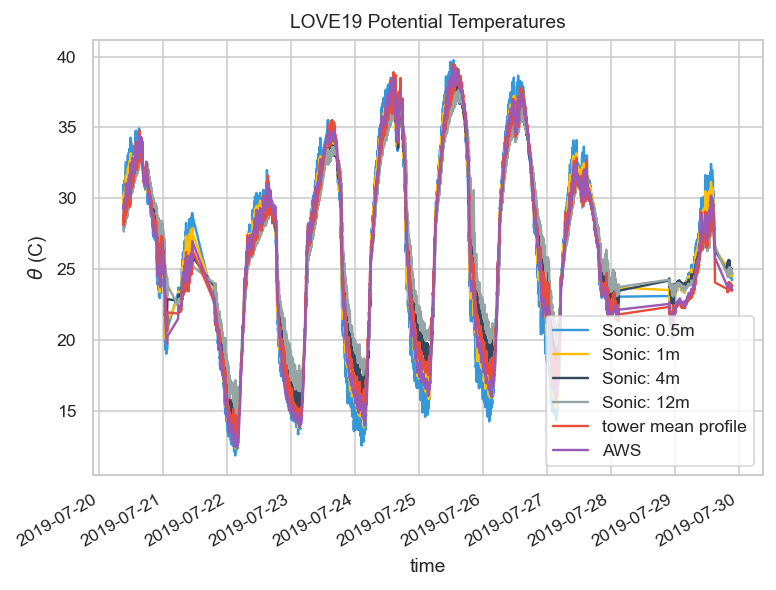

In [54]:
for name in sonic_1min_sub.names:
    sonic_1min_sub.theta.sel(names=name).plot(label='Sonic: ' + str(name.values))
tower_1min.mean(dim='xyz').theta_mean.plot(label='tower mean profile')
aws_2m_theta.plot(label='AWS')
plt.gca().set_title('LOVE19 Potential Temperatures')
plt.gca().set_ylabel(r'$\theta$ (C)')
plt.legend()

### 4.4.2 data @ 10-minute time scale

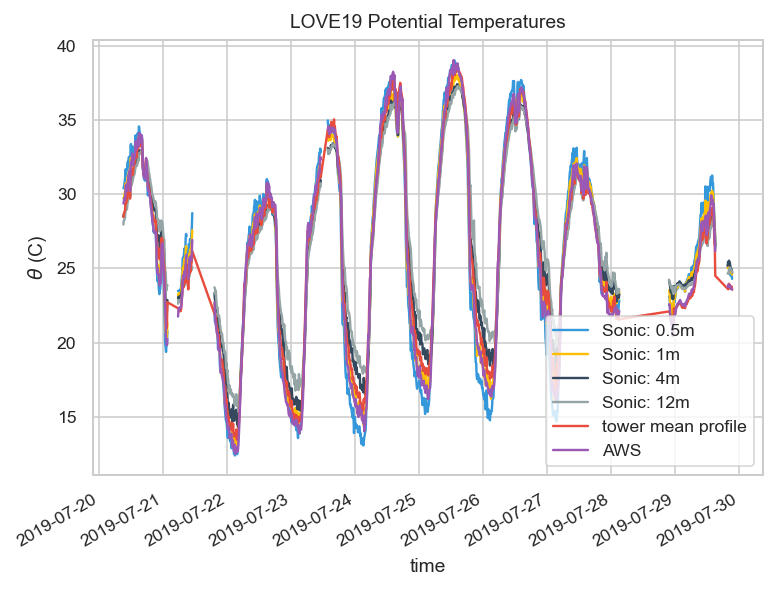

In [55]:
for name in sonic_1min_sub.names:
    sonic_10min_sub.theta.sel(names=name).plot(label='Sonic: ' + str(name.values))
tower_10min.mean(dim='xyz').theta_mean.plot(label='tower mean profile')
aws_2m_theta_10min.plot(label='AWS')
plt.gca().set_title('LOVE19 Potential Temperatures')
plt.gca().set_ylabel(r'$\theta$ (C)')
plt.legend()

That looks quite nice. The reason we have lines through periods with nans is that I dropeed them from the xarray Datasets. That means the python plotting routine draws lines through the gaps instead of leaving them blank if we left the nans in. This reduces the size of the data, which speeds up analysis below.

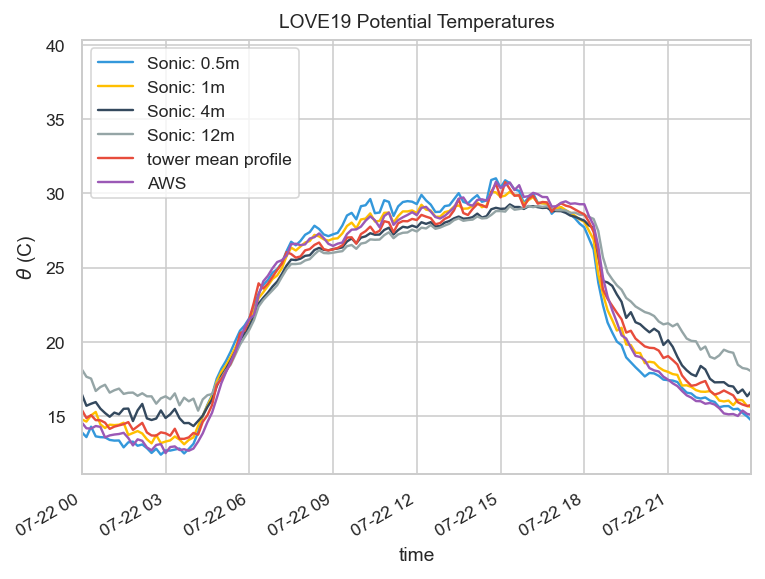

In [56]:
for name in sonic_1min_sub.names:
    sonic_10min_sub.theta.sel(names=name).plot(label='Sonic: ' + str(name.values))
tower_10min.mean(dim='xyz').theta_mean.plot(label='tower mean profile')
aws_2m_theta_10min.plot(label='AWS')
plt.gca().set_xlim('2019-07-22', '2019-07-22 23:59')
plt.gca().set_title('LOVE19 Potential Temperatures')
plt.gca().set_ylabel(r'$\theta$ (C)')
plt.legend()

## 4.5 Output these data

It should be useful to have these homogenized data easily available for other analysis.

In [57]:
sonic_1min_sub.attrs['processing'] = (
    '1min perturbation time scale. ' +
    'sonic temperatures converted to air temperature ' + 
    'and potential temperature (referenced to sea level pressure). ' +
    'Quality-controlled removing hour intervals containing 5-sigma dT/dt. ' +
    'Subset to the period with (higher quality) tower data')

sonic_10min_sub.attrs['processing'] = (
    '1min perturbation time scale aggregated to 10min means. ' +
    'sonic temperatures converted to air temperature ' + 
    'and potential temperature (referenced to sea level pressure). ' +
    'Quality-controlled removing hour intervals containing 5-sigma dT/dt. ' +
    'Subset to the period with (higher quality) tower data')

aws_2m_theta.attrs['processing'] = (
    'Original 1min averaging time scale. ' +
    'Air temperatures converted to potential temperature (referenced to sea level pressure). '
    'Subset to the period with (higher quality) tower and sonic data.')

aws_2m_theta_10min.attrs['processing'] = (
    'Original 1min averaging time scale aggregated to 10min means. ' +
    'Air temperatures converted to potential temperature (referenced to sea level pressure). '
    'Subset to the period with (higher quality) tower and sonic data.')

tower.attrs['processing'] = (
    'Original ~10s time step. ' +
    'DTS temperatures converted to potential temperature (referenced to sea level pressure). '
    'Subset to the period with (higher quality) tower and sonic data.')

tower_1min.attrs['processing'] = (
    'Original ~1s time step aggregated to 1min means. ' +
    'DTS temperatures converted to potential temperature (referenced to sea level pressure). '
    'Subset to the period with (higher quality) tower and sonic data.')

tower_10min.attrs['processing'] = (
    'Original ~10s time step aggregated to 10min means. ' +
    'DTS temperatures converted to potential temperature (referenced to sea level pressure). '
    'Subset to the period with (higher quality) tower and sonic data.')

In [58]:
os.chdir(dir_homogenized_data)

sonic_1min_sub.to_netcdf('sonics_pot-temp_1min_qc_tower-subset.v2-2021-06-01.nc')
sonic_10min_sub.to_netcdf('sonics_pot-temp_10min_qc_tower-subset.v2-2021-06-01.nc')
aws_2m_theta.to_netcdf('aws_pot-temp_1min_qc_tower-subset.v2-2021-06-01.nc')
aws_2m_theta_10min.to_netcdf('aws_pot-temp_10min_qc_tower-subset.v2-2021-06-01.nc')
tower.to_netcdf('tower_pot-temp_1s_qc_tower-subset.v2-2021-06-01.nc')
tower_1min.to_netcdf('tower_pot-temp_1min_qc_tower-subset.v2-2021-06-01.nc')
tower_10min.to_netcdf('tower_pot-temp_10min_qc_tower-subset.v2-2021-06-01.nc')